# Flux-ratios pipeline modeling tests

In [1]:
!nvidia-smi

# from google.colab import drive
# drive.mount('/content/drive')

#import gigalens
!pip install corner
!pip install lenstronomy==1.13.2
!pip install gigalens --no-deps

# added line

Tue Dec 23 18:52:04 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   33C    P0             56W /  400W |       0MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
import sys
# if '/content/drive/MyDrive/Colab Notebooks' not in sys.path:
#     sys.path.append('/content/drive/MyDrive/Colab Notebooks')
# # import modeling functions
from src.flux_ratios_pipeline_funcs import *

# import gigalens functions
from gigalens.tf.inference import ModellingSequence
from gigalens.tf.model import ForwardProbModel, BackwardProbModel
from gigalens.model import PhysicalModel
from gigalens.tf.simulator import LensSimulator
from gigalens.simulator import SimulatorConfig
from gigalens.tf.profiles.light import sersic
from gigalens.tf.profiles.mass import sis, shear, epl, sie

ModuleNotFoundError: No module named 'src'

## Simulation tests

In [ ]:
from tensorflow_probability import distributions as tfd, bijectors as tfb

truth = [
    [
        {'theta_E': 0.167, 'gamma': 2.013, 'e1': 0.049, 'e2': 0.083, 'center_x': 0.005, 'center_y': 0.011},  # mass distribution model
        {'gamma1': 0.078, 'gamma2': 0.015}  # external shear
    ],
    [
        {'R_sersic': 0.350, 'n_sersic': 2.586, 'e1': -0.262, 'e2': 0.239, 'center_x': 0.011, 'center_y': 0.005, 'Ie': 25.055} # lens light
    ],
    [
        {'center_x': 0.004, 'center_y': 0.009, 'Ie': 2815.973}  # source light
    ]
]

phys_model = PhysicalModel(
    [
        epl.EPL(50),
        shear.Shear()
    ],
    [
        sersic.SersicEllipse(),
    ],
    [
        Point()
    ]
)
##########################################################
lens_prior = tfd.JointDistributionSequential(
  [tfd.JointDistributionNamed(
      dict(
          theta_E=tfd.Uniform(low = 0.0, high = 0.3),
          gamma=tfd.TruncatedNormal(2, 0.25, 1.5, 2.5),
          e1=tfd.Normal(0, 0.1),
          e2=tfd.Normal(0, 0.1),
          center_x=tfd.Normal(0, 0.1),
          center_y=tfd.Normal(0, 0.1),
          )),
   tfd.JointDistributionNamed(
       dict(
           gamma1=tfd.Normal(0, 0.1),
           gamma2=tfd.Normal(0, 0.1),
          ),),])
###########################################################
lens_prior_trunc_normal = tfd.JointDistributionSequential(
  [tfd.JointDistributionNamed(
      dict(
          theta_E=tfd.Uniform(low = 0.0, high = 0.3),
          gamma=tfd.TruncatedNormal(2, 0.25, 1.5, 2.5),
          e1=tfd.TruncatedNormal(0, 0.1, -0.2, 0.2),
          e2=tfd.TruncatedNormal(0, 0.1, -0.2, 0.2),
          center_x=tfd.TruncatedNormal(0, 0.1, -0.2, 0.2),
          center_y=tfd.TruncatedNormal(0, 0.1, -0.2, 0.2),
          )),
   tfd.JointDistributionNamed(
       dict(
           gamma1=tfd.TruncatedNormal(0, 0.1, -0.2, 0.2),
           gamma2=tfd.TruncatedNormal(0, 0.1, -0.2, 0.2),
          ),),])
########################################################
lens_prior_uniform = tfd.JointDistributionSequential(
  [tfd.JointDistributionNamed(
      dict(
          theta_E=tfd.Uniform(low = 0.0, high = 0.3),
          gamma=tfd.Uniform(1., 2.8,),
          e1=tfd.Uniform(-0.1, 0.1),
          e2=tfd.Uniform(-0.1, 0.1),
          center_x=tfd.Uniform(-0.1, 0.1),
          center_y=tfd.Uniform(-0.1, 0.1),
          )),
   tfd.JointDistributionNamed(
       dict(
           gamma1=tfd.Uniform(-0.1, 0.1),
           gamma2=tfd.Uniform(-0.1, 0.1),
          ),),])

prior = tfd.JointDistributionSequential(
    [lens_prior_trunc_normal,]
)

delta_pix = 0.0006
supersample = 1
num_pix = 750

prob_model = ForwardProbModel(prior, 0, background_rms=0.2, exp_time=100)
example = lens_prior.sample(seed = 0)
size = int(tf.size(tf.nest.flatten(example)))

# kernel = np.load('/content/drive/MyDrive/point-source-updates/F475W-epsf.npy').astype(np.float32)
sim_config = SimulatorConfig(delta_pix=delta_pix, num_pix=num_pix, supersample=supersample)
lens_sim = LensSimulator(phys_model, sim_config, bs=1)

Brighest points reshaped into x, y:

x: tf.Tensor(
[[-0.1689    ]
 [-0.0615    ]
 [ 0.16350001]
 [ 0.06090001]], shape=(4, 1), dtype=float32)

y: tf.Tensor(
[[ 0.04590001]
 [-0.1359    ]
 [-0.0651    ]
 [ 0.15630001]], shape=(4, 1), dtype=float32)


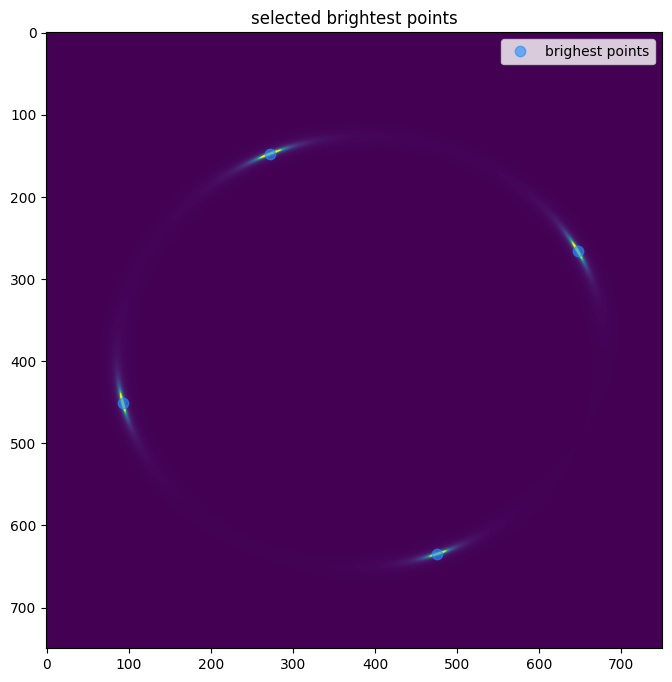

In [ ]:
sim_image = lens_sim.simulate(truth)

# simulated image
plt.figure(figsize=(10, 8))
plt.imshow(sim_image, vmin=0, vmax=10)
plt.grid(False)

lens_omitted_img= lens_sim.simulate([truth[0],[],truth[2]]) # Omit lens light
#plt.imshow(lens_omitted_img, vmin=0, vmax=10)
#plt.grid(False)
#plt.show()

# locating images
converter = BrightestPoints(number_of_images = 4, num_pixels=num_pix, grid_size=int(num_pix/2), delta_pix=delta_pix, supersample=1)
brightest_pixels = converter.find_brightest_points(lens_omitted_img)
plt.plot(brightest_pixels[:, 1], brightest_pixels[:, 0], ".", ms = 15, color = "dodgerblue", alpha = 0.6, label = "brighest points")
plt.title("selected brightest points")
plt.legend()
x_arcsec, y_arcsec = converter.pix_to_arcsec(brightest_pixels)
chains = 1
x = tf.repeat(x_arcsec[..., tf.newaxis], [chains], axis=-1)
y = tf.repeat(y_arcsec[..., tf.newaxis], [chains], axis=-1)
print("Brighest points reshaped into x, y:")
print("\nx:", x)
print("\ny:", y)

## Model test 1

In [ ]:
lens_prior = tfd.JointDistributionSequential( #UNIFORM PRIOR
  [tfd.JointDistributionNamed(
      dict(
          theta_E=tfd.Uniform(low = 0.0, high = 0.3),
           # gamma=tfd.Uniform(1.8, 2.3,),
           # gamma=tfd.Uniform(1.5, 2.5,),
           # gamma=tfd.Uniform(1., 3.,),
          gamma=tfd.TruncatedNormal(2, 0.25, 1.5, 2.5),
           # e1=tfd.Uniform(-0.2, 0.2),
           # e2=tfd.Uniform(-0.2, 0.2),
          e1=tfd.Normal(0, 0.1),
          e2=tfd.Normal(0, 0.1),
          #  e1=tfd.Uniform(-0.2, 0.2),
          #  e2=tfd.Uniform(-0.2, 0.2),
          center_x=tfd.Normal(0, 0.1),
          center_y=tfd.Normal(0, 0.1),
           # center_x=tfd.Uniform(-0.2, 0.2),
           # center_y=tfd.Uniform(-0.2, 0.2),
          )
      ),
   tfd.JointDistributionNamed(
       dict(
           gamma1=tfd.Normal(0, 0.1),
           gamma2=tfd.Normal(0, 0.1),
          # gamma1=tfd.Uniform(-0.2, 0.2),
          # gamma2=tfd.Uniform(-0.2, 0.2),
          ),
       ),
  ]
  )


#prior = tfd.JointDistributionSequential(
#    [lens_prior,]
#)


#prob_model = ForwardProbModel(prior, observed_img, background_rms=background_rms, exp_time=exp_time)

#example = lens_prior.sample(seed = 0)
#size = int(tf.size(tf.nest.flatten(example)))

In [ ]:
# other system
prior = tfd.JointDistributionSequential([lens_prior_uniform,])
prob_model_uniform = ForwardProbModel(prior, 0, background_rms=0.2, exp_time=100)

prior = tfd.JointDistributionSequential([lens_prior_trunc_normal,])
prob_model = ForwardProbModel(prior, 0, background_rms=0.2, exp_time=100)


delta_pix = 0.0006
num_pix = 750
truth_test = [[
        {'theta_E': 0.150, 'gamma': 1.9, 'e1': 0.029, 'e2': 0.053, 'center_x': -0.02, 'center_y': 0.025},
        {'gamma1': 0.012, 'gamma2': -0.025}
      ],
       [
        {'R_sersic': 0.350, 'n_sersic': 2.586, 'e1': -0.262, 'e2': 0.239, 'center_x': 0.011, 'center_y': 0.005, 'Ie': 25.055}
    ],

               [
        {'center_x': -0.018, 'center_y': 0.024, 'Ie': 2815.973},
      ],]


analysis = LensModelAnalysis(delta_pix=delta_pix, num_pix=num_pix, weight_dist=500,weight_flux=500, truth_test=truth_test,
                             prob_model=prob_model, prior=prior, prob_model_uniform=prob_model_uniform,
                             observed_data = None, simulation = True, flux_ratios = True)
analysis.run_map(n_map = 5000, n_steps = 3000)
analysis.run_vi()
samples_phys = analysis.run_hmc(n_hmc=50, num_burnin_steps=200, num_results=1000)


Simulated image and brightest points:



NameError: name 'lens_sim' is not defined